In [447]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt

In [448]:
df = pd.read_excel('../data/Handball Woman European Data Set.xlsx', index_col=0)

In [449]:
df.tail(6)

,Phase,Match,Team,No,Name,Goals,Shots,%,7m%,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,YC,RC,2M,2+2,AS,R7,ST,BS,P7,TO,Time,scoring,MVP
1494,FINAL,FRA-NOR,NOR,13,DALE Kari,1,1,100,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,60.000000,0.2,0
1495,FINAL,FRA-NOR,NOR,16,LUNDE Katrine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.283333,0.0,0
1496,FINAL,FRA-NOR,NOR,20,JACOBSEN Marit,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0,0
1497,FINAL,FRA-NOR,NOR,23,HERREM Camilla,3,4,75,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,37.000000,3.1,0
1498,FINAL,FRA-NOR,NOR,24,SOLBERG-ISAKSEN Sanna Charlotte,1,2,50,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.000000,0.3,0
1499,FINAL,FRA-NOR,NOR,25,BREISTOL Kristine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0,0


In [450]:
df.dtypes

Phase          object
Match          object
Team           object
No              int64
Name           object
Goals           int64
Shots           int64
%               int64
7m%             int64
7mPGoals        int64
7mPMissed       int64
6mCGoals        int64
6mCMissed       int64
WingGoals       int64
WingMissed      int64
BTGoals         int64
BTMissed        int64
FBGoals         int64
FBMissed        int64
FTOGoals        int64
FTOMissed       int64
9mGoals         int64
9mMissed        int64
YC              int64
RC              int64
2M              int64
2+2             int64
AS              int64
R7              int64
ST              int64
BS              int64
P7              int64
TO              int64
Time          float64
scoring       float64
MVP             int64
dtype: object

# Clustering inicial

Aproximación inicial utilizando los datos agregados con todos los goles y lanzamientos. Agrupamos los datos de esas dos variables por el nombre de la jugadora.

In [453]:
simplified_df = df[['Name', 'Goals', 'Shots']]
players_df = simplified_df.groupby('Name').sum().reset_index()
players_df

,Name,Goals,Shots
0,ABBINGH Lois,35,67
1,ABINA Ana,0,0
2,ABINA Ema,0,1
3,AGBABA Jelena,2,2
4,ARDERIUS Silvia,3,6
...,...,...,...
265,ZYCH Aleksandra,4,12
266,van KREIJ Harma,1,1
267,van WETERING Bo,18,35
268,van der HEIJDEN Laura,21,40


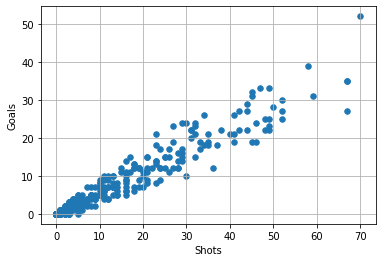

In [455]:
X = players_df[['Shots', 'Goals']]

plt.scatter(X['Shots'], X['Goals'], s=30)
plt.xlabel('Shots')
plt.ylabel('Goals')
plt.grid()
plt.show()

In [457]:
from sklearn.mixture import GaussianMixture

cv_types = ['spherical', 'tied', 'diag', 'full']
n_components_range = range(1, 10)

BIC = []
lowest_bic = np.infty
best_cv = 'full'
best_k = -1

for cv_type in cv_types:
    for k in n_components_range:
        EM = GaussianMixture(n_components=k, covariance_type=cv_type, init_params='random')
        EM.fit(X)
        
        BIC.append(EM.bic(X))
        
        if BIC[-1] < lowest_bic:
            lowest_bic = BIC[-1]
            best_cv = cv_type
            best_k = k
            
print("Mejor valor K:", best_k)
print("Mejor tipo de Covarianza:", best_cv)

Mejor valor K: 8
Mejor tipo de Covarianza: spherical


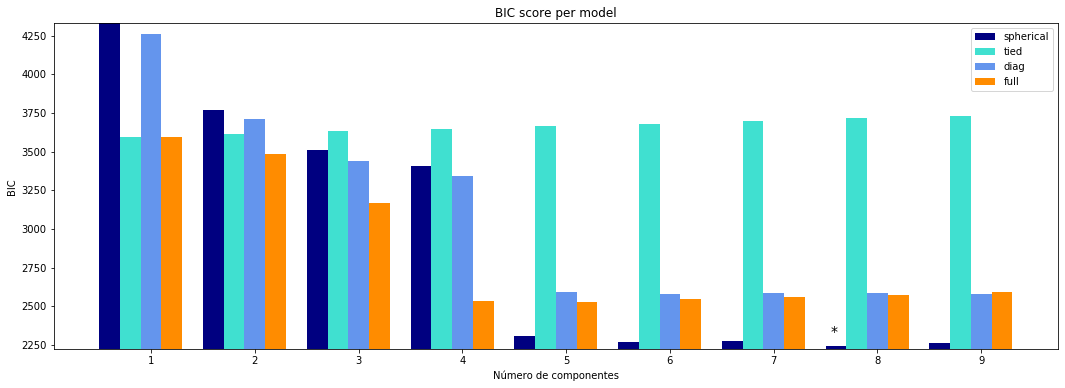

In [469]:
import itertools
import matplotlib.pyplot as plt

color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])

plt.figure(figsize=(18, 6))
bars = []
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos,
                        BIC[i * len(n_components_range):(i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([min(BIC) * 1.01 - .01 * max(BIC), max(BIC)])

plt.title('BIC score per model')
plt.xlabel('Número de componentes')
plt.ylabel('BIC')
plt.legend([b[0] for b in bars], cv_types)

xpos = np.mod(np.argmin(BIC), len(n_components_range)) + .55 + .2 * np.floor(np.argmin(BIC) / len(n_components_range))
plt.text(xpos, min(BIC) * 0.97 + .03 * max(BIC), '*', fontsize=14)

plt.show()

In [459]:
print(f"Expectation-Maximization with K={best_k} and covariance '{best_cv}'")
EM = GaussianMixture(n_components=best_k, covariance_type=best_cv, init_params='random')
EM.fit(X)
labels =  EM.predict(X)

Expectation-Maximization with K=8 and covariance 'spherical'


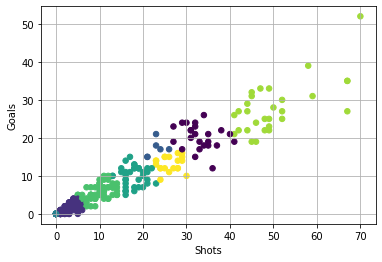

In [460]:
plt.scatter(X['Shots'], X['Goals'], c=labels, s=30)
plt.xlabel('Shots')
plt.ylabel('Goals')
plt.grid()
plt.show()

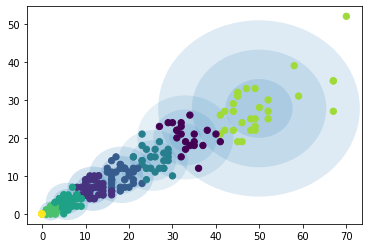

In [465]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

from matplotlib.patches import Ellipse

def plot_EM(model, X, grid=False):
    labels = model.fit(X).predict(X)
    
    ax = plt.gca()
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    
    w_factor = 0.2 / model.weights_.max()
    for pos, covar, w in zip(model.means_, model.covariances_, model.weights_):
        if covar.shape == (2, 2):
            U, s, Vt = np.linalg.svd(covar)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            width, height = 2 * np.sqrt(s)
        elif covar.shape == (2,):
            angle = 0
            width, height = 2 * np.sqrt(covar)
        else:
            angle = 0
            width = height = 2 * np.sqrt(covar)
    
        # Draw the Ellipse
        for nsig in range(1, 4):
            ax.add_patch(Ellipse(pos, nsig * width, nsig * height, angle, alpha=w * w_factor))
    
    if grid:
        plt.grid()
    plt.show()

plot_EM(EM, X)

# Variables significativas y limpieza de datos

Primero, vamos a analizar qué valores aparecen en cada variable. Descartamos previamente las que son indicativas, agregadas o no relevantes según la opinión del experto.

In [466]:
for column in df:
    if column in ['Phase', 'Match', 'Team', 'No', 'Name', '%', '7m%', 'YC', 'Time', 'scoring', 'MVP']:
        continue
    print(column, ':', sorted(df[column].unique()))

Goals : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Shots : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19]
7mPGoals : [0, 1, 2, 3, 4, 5, 6, 8, 9]
7mPMissed : [0, 1, 2]
6mCGoals : [0, 1, 2, 3, 4, 5, 6]
6mCMissed : [0, 1, 2, 3]
WingGoals : [0, 1, 2, 3, 4, 5, 6]
WingMissed : [0, 1, 2, 3, 4]
BTGoals : [0, 1, 2, 3, 4]
BTMissed : [0, 1, 2, 4]
FBGoals : [0, 1, 2, 3, 4, 6]
FBMissed : [0, 1, 2, 3]
FTOGoals : [0, 1]
FTOMissed : [0, 1]
9mGoals : [0, 1, 2, 3, 4, 5, 6, 7]
9mMissed : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RC : [0, 1]
2M : [0, 1, 2, 3]
2+2 : [0]
AS : [0, 1, 2, 3, 4, 5, 6, 7]
R7 : [0, 1, 2, 3, 4]
ST : [0, 1, 2, 3, 4, 5]
BS : [0, 1, 2, 3, 4, 5, 7]
P7 : [0, 1, 2, 3, 4]
TO : [0, 1, 2, 3, 4, 5, 6, 7, 8]


Podemos descartar la columna '2+2' ya que no tiene variabilidad (ninguna jugadora ha recibido esta sanción).

Nos quedamos con el resto de columnas, incluyendo el nombre (usado para agrupar posteriormente).

In [468]:
# ['Phase','Match','Team','No','Name','Goals','Shots','%','7m%','7mPGoals','7mPMissed','6mCGoals','6mCMissed','WingGoals','WingMissed','BTGoals','BTMissed','FBGoals','FBMissed','FTOGoals','FTOMissed','9mGoals','9mMissed','YC','RC','2M','2+2','AS','R7','ST','BS','P7','TO','Time','scoring','MVP']

valid_cols_df = df[['Name','7mPGoals','7mPMissed','6mCGoals','6mCMissed','WingGoals','WingMissed','BTGoals','BTMissed','FBGoals','FBMissed','FTOGoals','FTOMissed','9mGoals','9mMissed','RC','2M','AS','R7','ST','BS','P7','TO']]

print(valid_cols_df.shape)
valid_cols_df.dtypes

(1500, 23)


Name          object
7mPGoals       int64
7mPMissed      int64
6mCGoals       int64
6mCMissed      int64
WingGoals      int64
WingMissed     int64
BTGoals        int64
BTMissed       int64
FBGoals        int64
FBMissed       int64
FTOGoals       int64
FTOMissed      int64
9mGoals        int64
9mMissed       int64
RC             int64
2M             int64
AS             int64
R7             int64
ST             int64
BS             int64
P7             int64
TO             int64
dtype: object

Agrupamos los datos por el nombre de la jugadora, agregando todos sus datos. En este caso, lo que más sentido es utilizar la suma para obtener sus estadísticas globales en todo el Europeo.

In [402]:
players_df = valid_cols_df.groupby('Name').sum().reset_index()
players_df

,Name,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO
0,ABBINGH Lois,15,6,1,1,3,2,0,0,1,1,0,0,15,22,0,4,24,0,1,2,2,21
1,ABINA Ana,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ABINA Ema,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
3,AGBABA Jelena,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ARDERIUS Silvia,0,0,1,1,2,0,0,1,0,0,0,0,0,1,0,1,2,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,ZYCH Aleksandra,0,0,0,0,0,2,1,0,0,0,0,0,3,6,0,2,2,0,1,3,1,5
266,van KREIJ Harma,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
267,van WETERING Bo,0,0,0,0,12,15,0,0,6,2,0,0,0,0,0,0,2,1,7,0,1,3
268,van der HEIJDEN Laura,0,0,0,0,5,1,7,4,0,0,0,0,9,14,0,1,11,5,1,0,2,10


# Outliers

In [403]:
from sklearn.cluster import KMeans

K = 5
values_df = players_df.drop('Name', 1)
SSE = []

N = len(players_df)
for i in range(N):
    X = values_df.drop(i)
    
    km = KMeans(K, 'random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    distances = km.fit_transform(X) # Distancias de cada punto a cada clúster
    distances = np.min(distances, axis=1) # Distancias de cada punto a su clúster (el más cercano, mínima distancia)
    
    SSE.append((distances**2).sum())

Outliers found at: [157, 162, 166, 176]


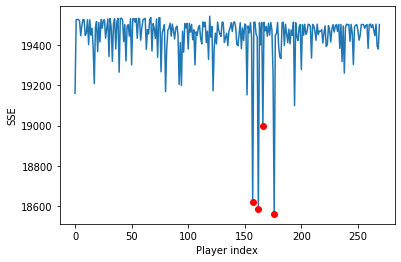

,Name,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO
157,MICIJEVIC Camila,0,0,3,1,2,2,2,0,0,0,0,0,28,29,0,4,24,1,5,13,7,22
162,MORK Nora,29,6,2,0,8,6,6,2,1,0,0,0,6,4,0,0,25,8,4,0,1,11
166,NEAGU Cristina,8,4,2,1,1,1,0,2,1,2,0,0,15,30,0,0,29,1,0,0,0,14
176,OFTEDAL Stine,0,0,1,3,1,3,18,9,3,2,0,0,8,11,0,1,41,5,0,0,1,19


In [404]:
sigma = np.std(SSE)
mu = np.mean(SSE)
umbral = 3
outliers = []
for i in range(N):
    if abs(SSE[i] - mu) > umbral * sigma:
        outliers.append(i)

print('Outliers found at:', outliers)

plt.plot(SSE)
for index in outliers:
    plt.plot(index, SSE[index], marker='o', color='red')
plt.xlabel('Player index')
plt.ylabel('SSE')
plt.show()


players_df.iloc[outliers]

In [405]:
players_df = players_df.drop(outliers).reset_index(drop=True)
players_df

,Name,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO
0,ABBINGH Lois,15,6,1,1,3,2,0,0,1,1,0,0,15,22,0,4,24,0,1,2,2,21
1,ABINA Ana,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ABINA Ema,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
3,AGBABA Jelena,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ARDERIUS Silvia,0,0,1,1,2,0,0,1,0,0,0,0,0,1,0,1,2,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,ZYCH Aleksandra,0,0,0,0,0,2,1,0,0,0,0,0,3,6,0,2,2,0,1,3,1,5
262,van KREIJ Harma,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
263,van WETERING Bo,0,0,0,0,12,15,0,0,6,2,0,0,0,0,0,0,2,1,7,0,1,3
264,van der HEIJDEN Laura,0,0,0,0,5,1,7,4,0,0,0,0,9,14,0,1,11,5,1,0,2,10


# Análisis PCA

Initial PCA with all variables. Not useful to reduce dimensionality, but to obtain the explained variances depending on the number of components taken in a later PCA.

In [406]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

scaler_names = ['Standard', 'MinMax']
scalers = [preprocessing.StandardScaler(), preprocessing.MinMaxScaler()]
n_components = [2, 3]

X = players_df.drop('Name', 1)

In [407]:
for scaler_name, scaler in zip(scaler_names, scalers):
    X_scaled = scaler.fit_transform(X)
    
    estimator = PCA(n_components=22)
    X_pca = estimator.fit_transform(X_scaled)
    
    explained_variances = estimator.explained_variance_ratio_.cumsum()
    
    for n in n_components:
        print(f"[scaler={scaler_name}, n={n}] Explained variance: {100*explained_variances[n-1]:.2f}% {estimator.explained_variance_ratio_[:n]}")

[scaler=Standard, n=2] Explained variance: 39.96% [0.26722902 0.13237361]
[scaler=Standard, n=3] Explained variance: 50.33% [0.26722902 0.13237361 0.10369339]
[scaler=MinMax, n=2] Explained variance: 46.46% [0.32792761 0.13664608]
[scaler=MinMax, n=3] Explained variance: 56.07% [0.32792761 0.13664608 0.09609305]


## Results

Explained variance with different configurations

| Scaler   | # Components | Explained variance | Variance per component   |
|----------|--------------|--------------------|--------------------------|
| Standard | 2            | ~39%               | [26.58%, 13.09%]         |
| Standard | 3            | ~50%               | [26.58%, 13.09%, 10.33%] |
| MinMax   | 2            | ~45%               | [31.04%, 13.87%]         |
| MinMax   | 3            | ~55%               | [31.04%, 13.87%, 10.33%] |

**Choice:** MinMaxScaler with 2 components

In [408]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA
estimator = PCA(n_components = 2)
X_pca = estimator.fit_transform(X_scaled)

players_df['PC1'] = X_pca[:,0]
players_df['PC2'] = X_pca[:,1]

explained_variance = estimator.explained_variance_ratio_.cumsum()[-1]
print("Total explained variance:", explained_variance)

Total explained variance: 0.46457368864736176


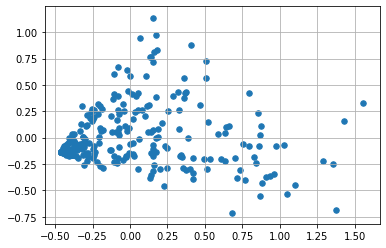

In [409]:
plt.scatter(players_df['PC1'], players_df['PC2'], s=30)
plt.grid()
plt.show()

## Significant variables analysis

Explained variance per colum

In [410]:
pd.DataFrame(
    np.matrix.transpose(estimator.components_),
    columns=[f'PC-{i+1}' for i in range(X_pca.shape[1])],
    index=X.columns)

,PC-1,PC-2
7mPGoals,0.128437,-0.019534
7mPMissed,0.145831,-0.103119
6mCGoals,0.100768,0.147748
6mCMissed,0.134523,0.106056
WingGoals,0.118327,0.421378
WingMissed,0.098697,0.367870
BTGoals,0.213036,-0.092677
BTMissed,0.201665,-0.102195
FBGoals,0.057711,0.221996
FBMissed,0.085990,0.364959


# Clustering Expectation-Maximization

In [427]:
from sklearn.mixture import GaussianMixture

X = players_df[['PC1', 'PC2']]

cv_types = ['spherical', 'tied', 'diag', 'full']
n_components_range = range(1, 10)

BIC = []
lowest_bic = np.infty
best_cv = 'full'
best_k = -1

for cv_type in cv_types:
    for k in n_components_range:
        gmm = GaussianMixture(n_components=k, covariance_type=cv_type, init_params='random')
        gmm.fit(X)
        
        BIC.append(gmm.bic(X))
        if BIC[-1] < lowest_bic:
            lowest_bic = BIC[-1]
            best_cv = cv_type
            best_k = k
            
print (f"Best K: {best_k}; Best covariance type: {best_cv}")

Best K: 5; Best covariance type: diag


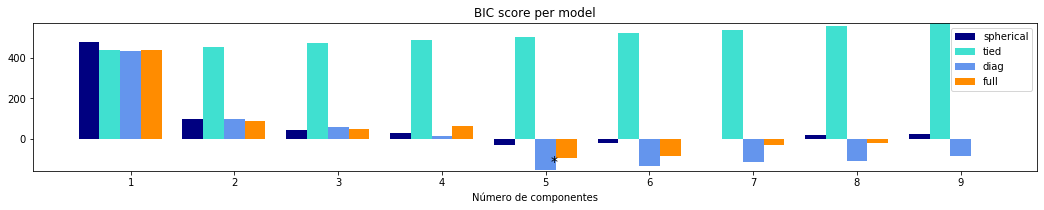

In [428]:
import itertools
import matplotlib.pyplot as plt

# Plot the BIC scores
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])
bars = []
plt.figure(figsize=(18, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, BIC[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([min(BIC) * 1.01 - .01 * max(BIC), max(BIC)])
plt.title('BIC score per model')
xpos = np.mod(np.argmin(BIC), len(n_components_range)) + .65 + .2 * np.floor(np.argmin(BIC) / len(n_components_range))
plt.text(xpos, min(BIC) * 0.97 + .03 * max(BIC), '*', fontsize=14)
spl.set_xlabel('Número de componentes')
spl.legend([b[0] for b in bars], cv_types)

In [431]:
EM = GaussianMixture(n_components=best_k, covariance_type=best_cv, init_params='random')
EM.fit(X)
labels =  EM.predict(X)

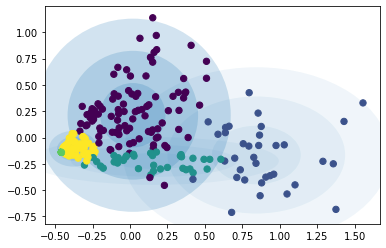

In [432]:
#plt.scatter(players_df['PC1'], players_df['PC2'], c=labels, s=30)
#plt.grid()
#plt.show()

plot_EM(EM, players_df[['PC1', 'PC2']])

# Clustering K-Means (old)

In [37]:
from sklearn import preprocessing 
min_max_scaler = preprocessing.MinMaxScaler()
datanorm = min_max_scaler.fit_transform(sum_df[['Goals', 'Shots']])

NameError: name 'sum_df' is not defined

In [23]:
# parameters
init = 'random' # initialization method 

# to run 10 times with different random centroids 
# to choose the final model as the one with the lowest SSE
iterations = 10

# maximum number of iterations for each single run
max_iter = 300 

# controls the tolerance with regard to the changes in the 
# within-cluster sum-squared-error to declare convergence

tol = 1e-04 

 # random seed
random_state = 0

from sklearn.cluster import KMeans
from sklearn import metrics

distortions = []
silhouettes = []

for i in range(2, 11):
    km = KMeans(i, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    labels = km.fit_predict(datanorm)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(datanorm, labels))

c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass init=random as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass init=random as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass init=random as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:72: Fut

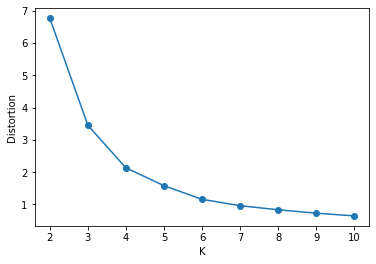

In [25]:
import matplotlib.pyplot as plt
plt.plot(range(2,11), distortions, marker='o')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

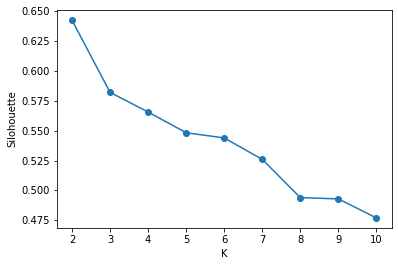

In [27]:
plt.plot(range(2,11), silhouettes , marker='o')
plt.xlabel('K')
plt.ylabel('Silohouette')
plt.show()

In [28]:
k = 10

km = KMeans(k, init, n_init = iterations ,
            max_iter= max_iter, tol = tol, random_state = random_state)

y_km = km.fit_predict(datanorm)

c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass init=random as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [29]:
from sklearn import metrics
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(datanorm, y_km))
      
print('Distortion: %.2f' % km.inertia_)

Silhouette Coefficient: 0.477
Distortion: 0.64


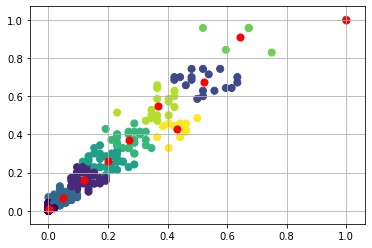

In [31]:
#plotting orginal points with color related to label
plt.scatter(datanorm[:,0], datanorm[:,1], c=km.labels_,s=50)
#plt.scatter(datanorm['Goals'], datanorm['Shots'], c=km.labels_,s=50)
# plotting centroids
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c='red',s=50)
# 
plt.grid()
plt.show()